# Word Embeddings Example

Suppose we have a vocabulary of words that we are working with. We want to represent each word as a vector, so that we can use it in a network. One way we could do this is by using **one-hot encoding**. Each word is represented as a vector of all zeros, except for the index corresponding to that word, which is represented as a 1. This means that each sentence is represented by a matrix with dimensions `<nb_words, nb_vocab>`.

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

sentence = ['the', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
vocabulary = dict([(word, i) for i, word in enumerate(set(sentence))])
print('Vocabulary:')
print(vocabulary, end='\n\n')

def one_hot_encode(sentence):
    ohe = np.zeros((len(sentence), len(vocabulary)))
    for i, word in enumerate(sentence):
        ohe[i, vocabulary[word]] = 1
    return ohe

print('One-hot encoded:')
print(one_hot_encode(sentence))

Vocabulary:
{'brown': 0, 'lazy': 1, 'jumped': 2, 'over': 3, 'fox': 4, 'dog': 5, 'the': 6}

One-hot encoded:
[[ 0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]]


The obvious problem is that this scales horribly! If we have 10000 words in our vocabulary, then we are representing each word with 9999 zeros and a single 1! On top of that, the vectors don't tell us anything about how the words are related. A better way is to use **word embeddings**.

There are different ways of generating word embeddings. In general, word embeddings are just a vector representation of words which hopefully conveys something about their meaning, for example:

`king - man + woman = queen`

Two popular methods for generating word embeddings are **word2vec** and **GloVe**. [Elsewhere](http://benjaminbolte.com/blog/2016/keras-gensim-embeddings.html) I have explained how to initialize these models using Gensim and pop the weights into Keras, which is a good idea for a lot of language models. For now, let's try generating some word embeddings using Keras that will help us solve a very simple task.

A task that I routinely encounter is having to remember whether or not my friends are red or green. I really wish I had a smarter way to do this, instead of chunking through mounds of data. Fortunately, just such a smarter way exists, and it is what I wanted to write about anyway! Let's see what it is.

In [2]:
import itertools
import numpy as np

sentences = '''
sam is red
hannah not red
hannah is green
bob is green
bob not red
sam not green
sarah is red
sarah not green'''.strip().split('\n')
is_green = np.asarray([[0, 1, 1, 1, 1, 0, 0, 0]], dtype='int32').T

for s, g in zip(sentences, is_green):
    print(s, '->', g)

sam is red -> [0]
hannah not red -> [1]
hannah is green -> [1]
bob is green -> [1]
bob not red -> [1]
sam not green -> [0]
sarah is red -> [0]
sarah not green -> [0]


Next, let's **tokenize** the sentences to get individual words, then generate our vocabulary and convert our sentences from words to indices.

In [3]:
tokenize = lambda x: x.strip().lower().split(' ')
sentences_tokenized = [tokenize(sentence) for sentence in sentences]
words = set(itertools.chain(*sentences_tokenized))

word2idx = dict((v, i) for i, v in enumerate(words))
idx2word = list(words)
print('Vocabulary:')
print(word2idx, end='\n\n')

to_idx = lambda x: [word2idx[word] for word in x] # convert a list of words to a list of indices
sentences_idx = [to_idx(sentence) for sentence in sentences_tokenized]
sentences_array = np.asarray(sentences_idx, dtype='int32')
print('Sentences:')
print(sentences_array)

Vocabulary:
{'sarah': 0, 'sam': 1, 'hannah': 2, 'is': 3, 'green': 4, 'not': 5, 'bob': 6, 'red': 7}

Sentences:
[[1 3 7]
 [2 5 7]
 [2 3 4]
 [6 3 4]
 [6 5 7]
 [1 5 4]
 [0 3 7]
 [0 5 4]]


Here's some parameters for our model. I chose to embed each word into a two-dimensional vector space, because that is easily visualized. For a vocabulary with around 20,000 words, it is common to use embeddings of around 100 to 200 dimensions, although this varies greatly by application.

In [4]:
sentence_maxlen = 3
n_words = len(words)
n_embed_dims = 2
print('%d words per sentence, %d in vocabulary, %d dimensions for embedding' % (sentence_maxlen, n_words, n_embed_dims))

3 words per sentence, 8 in vocabulary, 2 dimensions for embedding


Great! Now let's put together our model in Keras. It takes as inputs a list of indices as integers, then embeds them in a `n_embed_dims`-dimensional space, and then feeds them to a neural network which predicts what color they refer to. Don't worry about the network too much, just understand that the word embedding vectors are being trained on the data so that they provide a representation which is more useful for solving our problem.

In [5]:
from keras.layers import Input, Embedding, merge, Flatten, Reshape, Lambda
import keras.backend as K
from keras.models import Model

input_sentence = Input(shape=(sentence_maxlen,), dtype='int32')
input_embedding = Embedding(n_words, n_embed_dims)(input_sentence)
avepool = Lambda(lambda x: K.mean(x, axis=1, keepdims=True), output_shape=lambda x: (x[0], 1))
color_prediction = avepool(Reshape((sentence_maxlen * n_embed_dims,))(input_embedding))

Using Theano backend.


Lastly, let's fit the model. In Keras, we can easily specify that we want to use binary crossentropy for our loss function; no need to look up it's formula on Wikipedia!

In [6]:
predict_green = Model(input=[input_sentence], output=[color_prediction])
predict_green.compile(optimizer='sgd', loss='binary_crossentropy')

predict_green.fit([sentences_array], [is_green], nb_epoch=5000, verbose=0)
embeddings = predict_green.layers[1].W.get_value()

for i in range(n_words):
    print('{}: {}'.format(idx2word[i], embeddings[i]))

sarah: [-1.22824633 -1.17062831]
sam: [-1.19280672 -1.20614004]
hannah: [ 1.80140889  1.8014065 ]
is: [ 0.56213224  0.64294231]
green: [ 0.59127456  0.60197026]
not: [ 0.55490071  0.64983344]
bob: [ 1.83830953  1.77629972]
red: [ 0.59618628  0.59634411]


Awesome! Let's plot our results to see what kind of embeddings we learned.

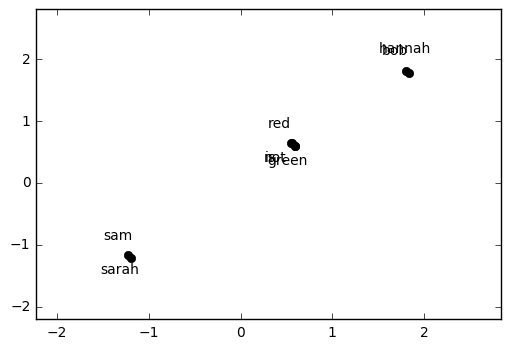

In [7]:
%matplotlib inline

x1, x2 = embeddings[:, 0], embeddings[:, 1]

import matplotlib
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.gca()
offsets_x = [random.randint(0, 1) * 0.6 - 0.3 for _ in range(n_words)]
offsets_y = [random.randint(0, 1) * 0.6 - 0.3 for _ in range(n_words)]
for i, ox, oy in zip(range(n_words), offsets_x, offsets_y):
    ax.plot(x1[i], x2[i], 'o', color='black')
    ax.annotate(idx2word[i], xy=[x1[i], x2[i]], xytext=[x1[i] + ox, x2[i] + oy])

ax.set_xlim(min(x1)-1, max(x1)+1)
ax.set_ylim(min(x2)-1, max(x2)+1)
plt.show()

Bob and Hannah (who were both green) are together in one corner, and Sarah and Sam (who were both red) are together in another corner, with the other parts floating in the middle. The network didn't learn anything unique about "not" or "is" or "green" or "red" because it those are higher-order correlations, and it is a simple linear model.

In more complex language modeling problems, word embeddings are often useful for providing a starting place for the network, which reduces the parameter search space and hopefully provides a better minimum for the loss function.